In [56]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import h5py
import numpy as np
np.set_printoptions(suppress=True)
import math
import matplotlib.pyplot as plt
import MEArec as mr
from collections import defaultdict
from utility_functions import clustering_plotting_functions
import spikeextractors as se
import spiketoolkit as st
import spikeinterface.comparison as sc
from tqdm.notebook import tqdm
import spikeinterface.widgets as sw
#import spikecomparison as sc
import spikeinterface.comparison as sc

# sklearn import errors
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

from sklearn.mixture import GaussianMixture
from sklearn import decomposition
from sklearn.mixture import GaussianMixture

from collections import namedtuple

TrainSpike = namedtuple('DataPoint', ['amps', 'waveforms', 'ch_locs', 'center_loc', 'spike_id', 'exp_id',\
                                      'min_waveform', 'min_amp'])
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
mpl.rcParams.update({'font.size': 12})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
recording_directory = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/'
augmented_data_path = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/save files 3/'
recording_name = 'recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5'
width = 40
amp_jitter = 0

recgen = mr.load_recordings(recording_directory + recording_name)
channel_positions = recgen.channel_positions
soma_positions = np.asarray([st.annotations['soma_position'] for st in recgen.spiketrains])
SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)

hf_AO = h5py.File(str(augmented_data_path) + 'model_data_gt_'+ str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')
amp_array = np.asarray(hf_AO['amplitude'])
channel_loc_array = np.asarray(hf_AO['channel_locations'])
waveforms_array = np.asarray(hf_AO['waveforms'])
center_loc_array = np.asarray(hf_AO['center_locations'])
spike_time_list = np.asarray(hf_AO['spike_times'])
spike_id_list = np.asarray(hf_AO['spike_ids'])
hf_AO.close()

hf_label_AO = h5py.File(str(augmented_data_path) + 'label_data_gt_' + str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')
neuron_loc_array = np.asarray(hf_label_AO['neuron_locations'])
neuron_array = np.asarray(hf_label_AO['neurons'])
hf_label_AO.close()

'''
hf_label_AO = h5py.File(str(augmented_data_path) + 'label_data_' + str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')
neuron_loc_array = np.asarray(hf_label_AO['neuron_loc_list'])
neuron_array = np.asarray(hf_label_AO['neuron_list'])
overlap_array = np.asarray(hf_label_AO['overlap_list'])
hf_label_AO.close()

'''

"\nhf_label_AO = h5py.File(str(augmented_data_path) + 'label_data_' + str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')\nneuron_loc_array = np.asarray(hf_label_AO['neuron_loc_list'])\nneuron_array = np.asarray(hf_label_AO['neuron_list'])\noverlap_array = np.asarray(hf_label_AO['overlap_list'])\nhf_label_AO.close()\n\n"

In [58]:
waveform_len = 60
results_path = "save files 3/" + "loc_predictions_"+str(width) + "_" + str(amp_jitter) + "_amp_jit_wave_"+str(waveform_len)+".txt"
all_vae_errors = defaultdict(list)
vae_locs_2D = defaultdict(list)
vae_locs_3D = defaultdict(list)
all_neuron_waveforms = defaultdict(list)
all_spike_times = defaultdict(list)
index = 0
with open(results_path,"r") as f:
    for result_string in f:
        result_tokens = [float(i) for i in result_string.split(',')]
        est_loc = [float(token) for token in result_tokens[0:3]]
        max_waveform = [float(token) for token in result_tokens[3:3+waveform_len]]
        spike_time = int(result_tokens[3+waveform_len])
        neuron_id = int(result_tokens[3+waveform_len+1])
        neuron_loc = soma_positions[neuron_id]
        vae_locs_2D[neuron_id].append([est_loc[1], est_loc[2]])
        vae_locs_3D[neuron_id].append([est_loc[0], est_loc[1], est_loc[2]])
        
        error_dist = np.linalg.norm(est_loc[1:3] - neuron_loc[1:3])
        all_neuron_waveforms[neuron_id].append(max_waveform)
        all_spike_times[neuron_id].append(spike_time)
        index += 1
        all_vae_errors[neuron_id].append(error_dist)
print(results_path)

save files 3/loc_predictions_40_0_amp_jit_wave_60.txt


In [59]:
spike_number = 0
neuron_error = 0
neuron_std = 0 
neuron_errors_all = []
neuron_stds_all = []
spike_errors_all = []
good_indices = [ 0,  7,  8, 10, 11, 12, 13, 14, 16, 19, 21, 22, 23, 25, 26, 27, 31, 33, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49]
bad_indices = list(set(list(range(50))) - set(good_indices))

for neuron in range(50):#good_indices:#range(50):
    if(len(all_vae_errors[neuron]) != 0):
        neuron_error = np.mean(all_vae_errors[neuron])
        neuron_std = np.std(all_vae_errors[neuron])
        spike_number += len(all_vae_errors[neuron])
        spike_errors_all = spike_errors_all + all_vae_errors[neuron]
        neuron_errors_all.append(neuron_error)
        neuron_stds_all.append(neuron_std)
print("Total Spike 2D Error: " + str(np.mean(spike_errors_all)) + " +- " + str(np.std(spike_errors_all)))
print("Total Neuron 2D Error: " + str(np.mean(neuron_errors_all)) + " +- " + str(np.mean(neuron_stds_all)))

Total Spike 2D Error: 9.8781940706246 +- 11.535070158085956
Total Neuron 2D Error: 10.851315021192889 +- 8.624780209331004


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

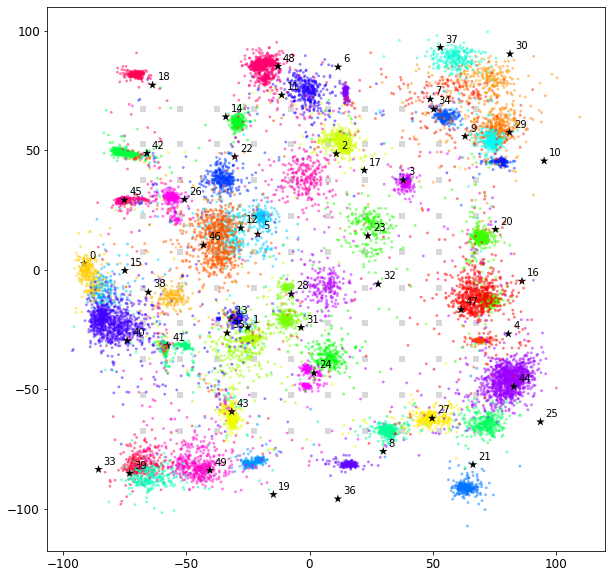

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
clustering_plotting_functions.plot2DLocations(channel_positions, range(50), vae_locs_3D, soma_positions, dims=[1,2], alpha=.5, ax=ax, annotate=True);

In [42]:
num_neurons = 50
cutout_start = 20
cutout_end = 20
pc_components = 2
alpha = 20
num_clusters = 60
covariance_type = 'spherical'
middle_frame = len(all_neuron_waveforms[0][0])//2

waveforms_list = []
for neuron in range(num_neurons):
    for waveform in all_neuron_waveforms[neuron]:
        waveforms_list.append(waveform[middle_frame-cutout_start:middle_frame+cutout_end])
waveforms_list = np.asarray(waveforms_list)

if(pc_components != 0):
    pca = decomposition.PCA(n_components=pc_components, whiten=True)
    pca.fit(waveforms_list)
    waveforms_pcs_array = pca.transform(waveforms_list)
    all_neuron_pcs = defaultdict(list)
    total_spikes = 0
    for neuron in range(num_neurons):
        for i, _ in enumerate(all_neuron_waveforms[neuron]):
            all_neuron_pcs[neuron].append(waveforms_pcs_array[i + total_spikes])
        total_spikes += len(all_neuron_waveforms[neuron])

cluster_data = []
labels = []
if(pc_components !=0):
    for neuron in range(num_neurons):
        for i, vae_loc in enumerate(vae_locs_3D[neuron]):
            cluster_data.append(np.concatenate((vae_loc[1:3], alpha*all_neuron_pcs[neuron][i])))
            labels.append(neuron)
    cluster_data = np.asarray(cluster_data)
else:
    for neuron in range(num_neurons):
        for i, vae_loc in enumerate(vae_locs_3D[neuron]):
            cluster_data.append((vae_loc[1:3]))
            labels.append(neuron)
    cluster_data = np.asarray(cluster_data)

clustering = GaussianMixture(n_components=num_clusters, covariance_type=covariance_type, random_state=0).fit(cluster_data)
labels =  clustering.predict(cluster_data)

#Make numpy extractor for method

SX=se.NumpySortingExtractor()
SX.set_sampling_frequency(32000)
times = []
for neuron in range(num_neurons):
    for time in all_spike_times[neuron]:
        times.append(time)
times = np.asarray(times)
for k in np.unique(labels):
    times_k=times[np.where(labels==k)[0]]
    times_k.sort()
    SX.add_unit(unit_id=k,times=times_k)

cmp = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX, n_jobs=1, match_score=0);
performance_measures = cmp.get_performance(method='pooled_with_average')

print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
print(performance_measures)

Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.794893
recall                  0.819620
precision               0.945819
false_discovery_rate    0.054181
miss_rate               0.180380
dtype: float64


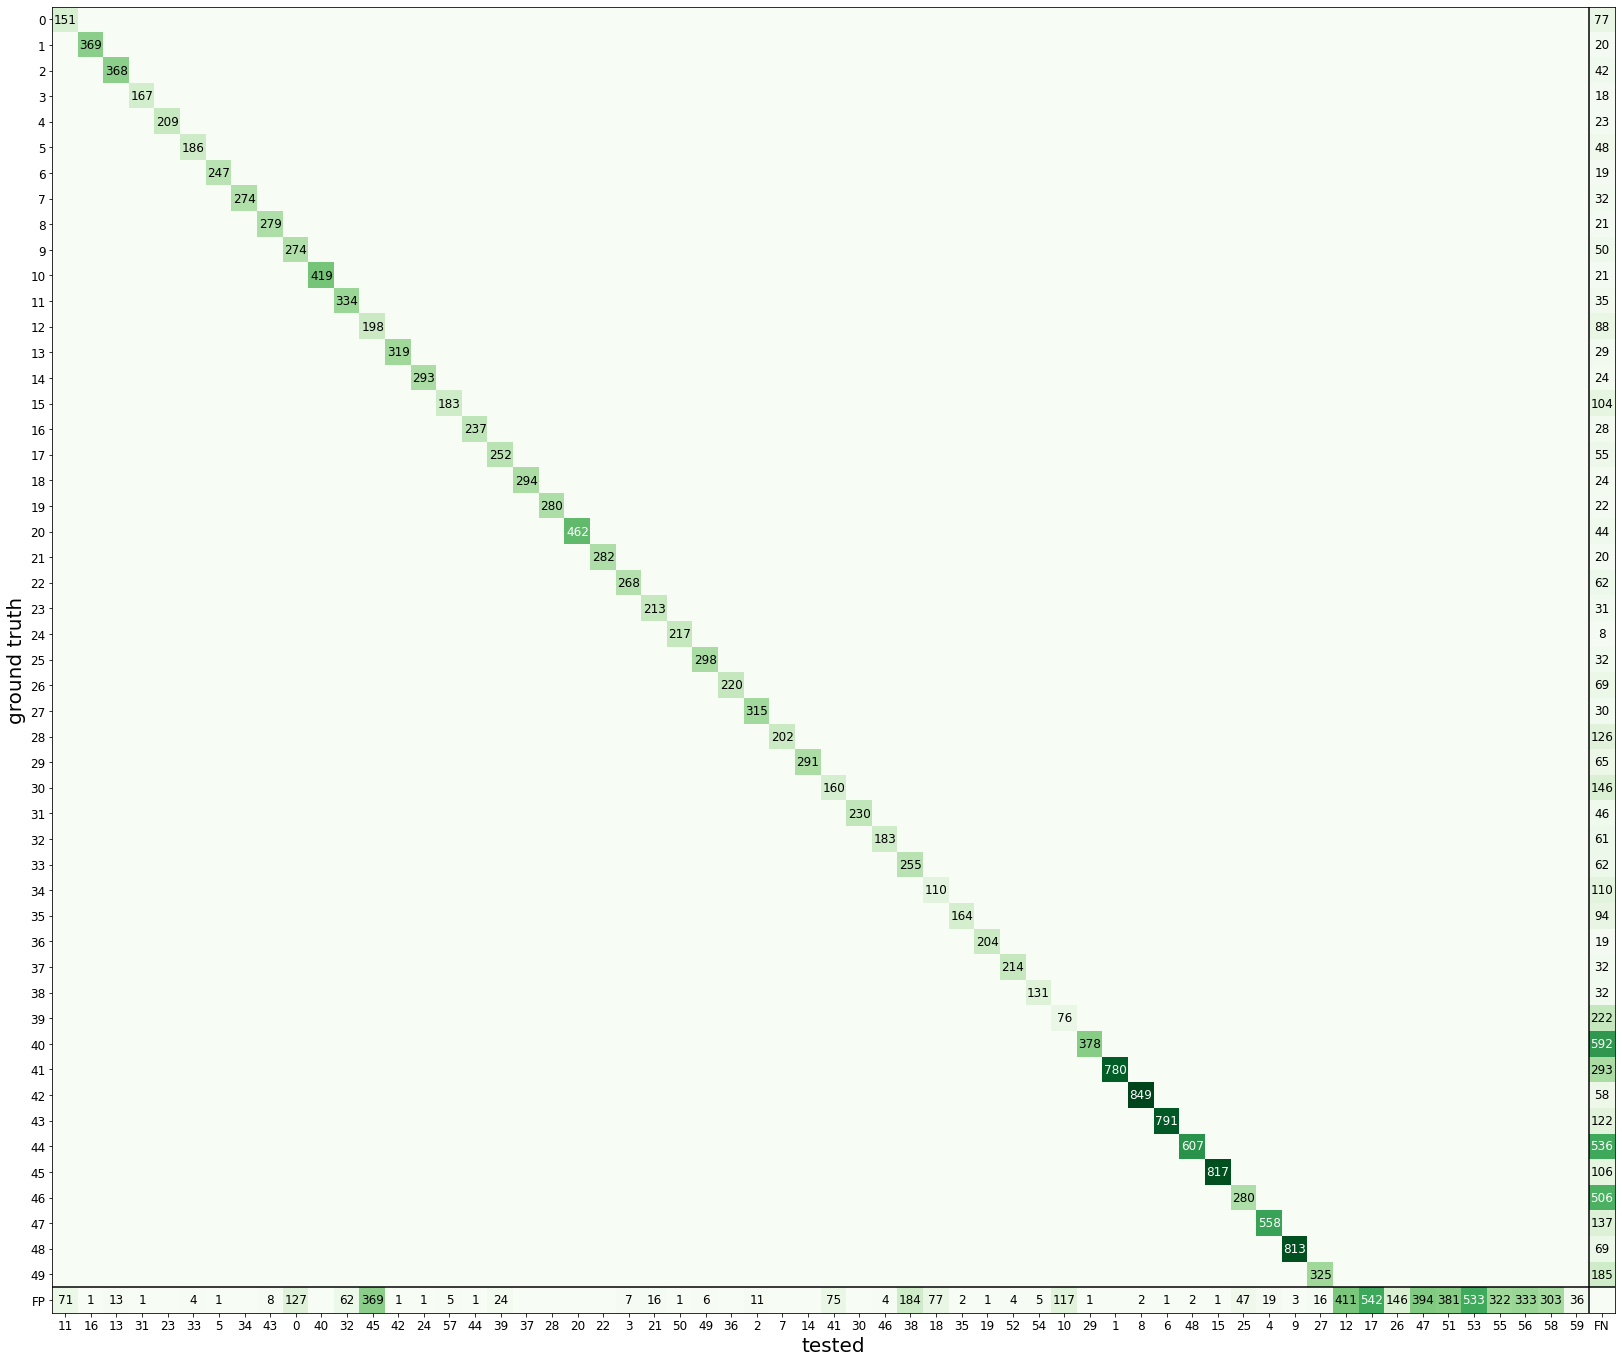

In [28]:
fig, ax = plt.subplots(figsize=(28,28))
w_conf = sw.plot_confusion_matrix(cmp, ax=ax)

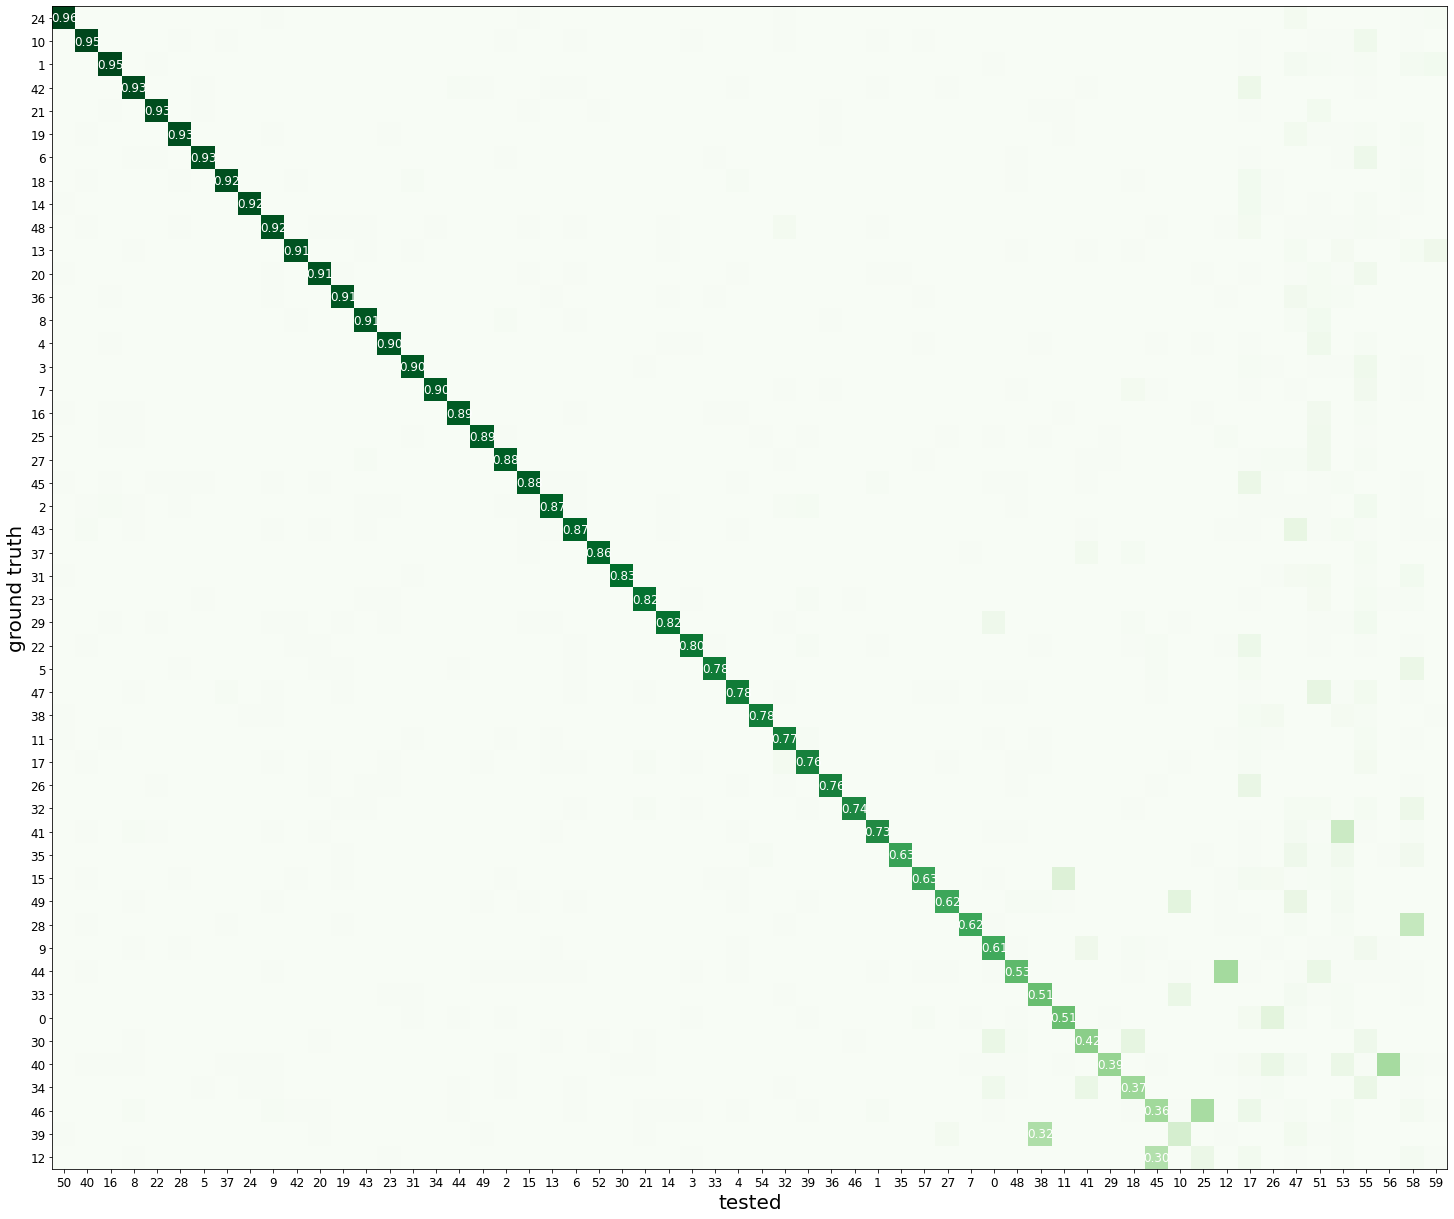

In [29]:
fig, ax = plt.subplots(figsize=(25,25))
w_agr = sw.plot_agreement_matrix(cmp, ax=ax)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

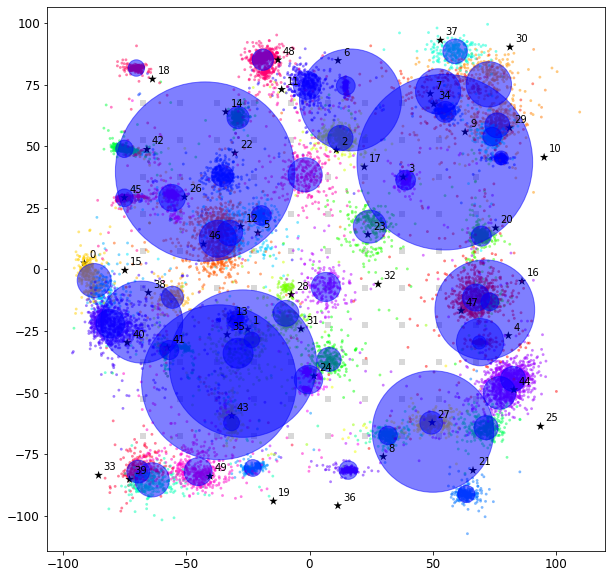

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# clustering_plotting_functions.plotClusterResults(channel_positions, cluster_data, labels, soma_positions, dims=[0,1], clustering_alg='gmm', alpha=.15, ax=ax, min_cluster_size=0)
for i, covar in enumerate(clustering.covariances_):
    mean = clustering.means_[i]
    if covariance_type == 'full':
        covariances = covar[:2, :2]
    elif covariance_type == 'diag':
        covariances = np.diag(covar[:2])
    elif covariance_type == 'spherical':
        covariances =  np.eye(mean.shape[0]) * covar
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1],
                              180 + angle, color='blue')
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect('equal', 'datalim')
clustering_plotting_functions.plot2DLocations(channel_positions, range(num_neurons), vae_locs_3D, soma_positions, dims=[1,2], alpha=.5, ax=ax);

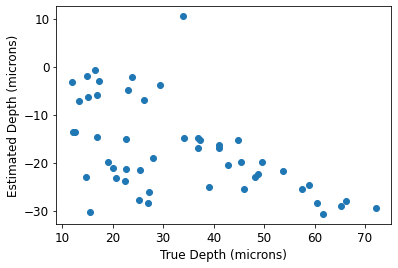

In [43]:
est_depths = []
real_depths = []
for neuron in range(50):
    real_depths.append(soma_positions[neuron][0])
    est_depths.append(np.mean(np.asarray(vae_locs_3D[neuron])[:,0]))
plt.scatter(real_depths, est_depths)
plt.ylabel("Estimated Depth (microns)")
plt.xlabel("True Depth (microns)");

## Mean Shift Clustering

In [44]:
from sklearn.cluster import MeanShift

clustering_vae= MeanShift(bandwidth=10).fit(cluster_data)
labels_vae =  clustering_vae.predict(cluster_data)

In [45]:
SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
SX_vae_ms=se.NumpySortingExtractor()
SX_vae_ms.set_sampling_frequency(32000)
times = []
for neuron in range(num_neurons):
    for time in all_spike_times[neuron]:
        times.append(time)
times = np.asarray(times)
for k in np.unique(labels_vae):
    times_k=times[np.where(labels_vae==k)[0]]
    times_k.sort()
    SX_vae_ms.add_unit(unit_id=k,times=times_k)

cmp_vae_ms = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX_vae_ms, n_jobs=1, match_score=0);
performance_measures_vae_ms = cmp_vae_ms.get_performance(method='pooled_with_average')

print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
print(performance_measures_vae_ms)

Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.821790
recall                  0.843408
precision               0.964234
false_discovery_rate    0.035766
miss_rate               0.156592
dtype: float64


## Searching parameters

  0%|          | 0/21 [00:00<?, ?it/s]

Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.653614
recall                  0.744998
precision               0.820346
false_discovery_rate    0.179654
miss_rate               0.255002
dtype: float64


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.256260
recall                  0.257049
precision               0.967666
false_discovery_rate    0.032334
miss_rate               0.742951
dtype: float64
Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.438758
recall                  0.449766
precision               0.942382
false_discovery_rate    0.057618
miss_rate               0.550234
dtype: float64
Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.548502
recall                  0.571266
precision               0.918074
false_discovery_rate    0.081926
miss_rate               0.428734
dtype: float64
Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.624183
recall                  0.675359
precision               0.878940
false_discovery_rate    0.121060
miss_rate               0.324641
dtype: float64
Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.654679
recall                  0.729134
precision               0.845437
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 1, PCs: 2, Num Clusters: 60
accuracy                0.244971
recall                  0.245054
precision               0.988077
false_discovery_rate    0.011923
miss_rate               0.754946
dtype: float64
Alpha: 1, PCs: 2, Num Clusters: 60
accuracy                0.430618
recall                  0.432989
precision               0.950518
false_discovery_rate    0.049482
miss_rate               0.567011
dtype: float64
Alpha: 1, PCs: 2, Num Clusters: 60
accuracy                0.557452
recall                  0.574357
precision               0.932537
false_discovery_rate    0.067463
miss_rate               0.425643
dtype: float64
Alpha: 1, PCs: 2, Num Clusters: 60
accuracy                0.627852
recall                  0.670788
precision               0.888360
false_discovery_rate    0.111640
miss_rate               0.329212
dtype: float64
Alpha: 1, PCs: 2, Num Clusters: 60
accuracy                0.653510
recall                  0.721693
precision               0.865334
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 2, PCs: 2, Num Clusters: 60
accuracy                0.220703
recall                  0.220721
precision               0.996616
false_discovery_rate    0.003384
miss_rate               0.779279
dtype: float64
Alpha: 2, PCs: 2, Num Clusters: 60
accuracy                0.435680
recall                  0.436559
precision               0.977161
false_discovery_rate    0.022839
miss_rate               0.563441
dtype: float64
Alpha: 2, PCs: 2, Num Clusters: 60
accuracy                0.554830
recall                  0.563111
precision               0.948049
false_discovery_rate    0.051951
miss_rate               0.436889
dtype: float64
Alpha: 2, PCs: 2, Num Clusters: 60
accuracy                0.638236
recall                  0.664489
precision               0.907093
false_discovery_rate    0.092907
miss_rate               0.335511
dtype: float64
Alpha: 2, PCs: 2, Num Clusters: 60
accuracy                0.675771
recall                  0.725482
precision               0.893513
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 3, PCs: 2, Num Clusters: 60
accuracy                0.192039
recall                  0.192060
precision               0.994683
false_discovery_rate    0.005317
miss_rate               0.807940
dtype: float64
Alpha: 3, PCs: 2, Num Clusters: 60
accuracy                0.421074
recall                  0.421548
precision               0.979703
false_discovery_rate    0.020297
miss_rate               0.578452
dtype: float64
Alpha: 3, PCs: 2, Num Clusters: 60
accuracy                0.559782
recall                  0.564053
precision               0.960010
false_discovery_rate    0.039990
miss_rate               0.435947
dtype: float64
Alpha: 3, PCs: 2, Num Clusters: 60
accuracy                0.637437
recall                  0.656214
precision               0.923925
false_discovery_rate    0.076075
miss_rate               0.343786
dtype: float64
Alpha: 3, PCs: 2, Num Clusters: 60
accuracy                0.685255
recall                  0.722154
precision               0.906107
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 4, PCs: 2, Num Clusters: 60
accuracy                0.169366
recall                  0.169366
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.830634
dtype: float64
Alpha: 4, PCs: 2, Num Clusters: 60
accuracy                0.402404
recall                  0.402589
precision               0.989856
false_discovery_rate    0.010144
miss_rate               0.597411
dtype: float64
Alpha: 4, PCs: 2, Num Clusters: 60
accuracy                0.545428
recall                  0.547726
precision               0.974103
false_discovery_rate    0.025897
miss_rate               0.452274
dtype: float64
Alpha: 4, PCs: 2, Num Clusters: 60
accuracy                0.652880
recall                  0.666284
precision               0.942175
false_discovery_rate    0.057825
miss_rate               0.333716
dtype: float64
Alpha: 4, PCs: 2, Num Clusters: 60
accuracy                0.687539
recall                  0.715397
precision               0.919076
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 5, PCs: 2, Num Clusters: 60
accuracy                0.150870
recall                  0.150872
precision               0.998182
false_discovery_rate    0.001818
miss_rate               0.849128
dtype: float64
Alpha: 5, PCs: 2, Num Clusters: 60
accuracy                0.383203
recall                  0.383374
precision               0.994408
false_discovery_rate    0.005592
miss_rate               0.616626
dtype: float64
Alpha: 5, PCs: 2, Num Clusters: 60
accuracy                0.545557
recall                  0.547098
precision               0.980441
false_discovery_rate    0.019559
miss_rate               0.452902
dtype: float64
Alpha: 5, PCs: 2, Num Clusters: 60
accuracy                0.657295
recall                  0.666020
precision               0.963341
false_discovery_rate    0.036659
miss_rate               0.333980
dtype: float64
Alpha: 5, PCs: 2, Num Clusters: 60
accuracy                0.690042
recall                  0.716857
precision               0.923350
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 6, PCs: 2, Num Clusters: 60
accuracy                0.122272
recall                  0.122272
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.877728
dtype: float64
Alpha: 6, PCs: 2, Num Clusters: 60
accuracy                0.363321
recall                  0.363406
precision               0.995168
false_discovery_rate    0.004832
miss_rate               0.636594
dtype: float64
Alpha: 6, PCs: 2, Num Clusters: 60
accuracy                0.531987
recall                  0.532990
precision               0.985947
false_discovery_rate    0.014053
miss_rate               0.467010
dtype: float64
Alpha: 6, PCs: 2, Num Clusters: 60
accuracy                0.654316
recall                  0.661254
precision               0.967539
false_discovery_rate    0.032461
miss_rate               0.338746
dtype: float64
Alpha: 6, PCs: 2, Num Clusters: 60
accuracy                0.709187
recall                  0.725645
precision               0.953281
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 7, PCs: 2, Num Clusters: 60
accuracy                0.100718
recall                  0.100718
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.899282
dtype: float64
Alpha: 7, PCs: 2, Num Clusters: 60
accuracy                0.332874
recall                  0.332966
precision               0.994952
false_discovery_rate    0.005048
miss_rate               0.667034
dtype: float64
Alpha: 7, PCs: 2, Num Clusters: 60
accuracy                0.518337
recall                  0.519181
precision               0.987611
false_discovery_rate    0.012389
miss_rate               0.480819
dtype: float64
Alpha: 7, PCs: 2, Num Clusters: 60
accuracy                0.639649
recall                  0.644895
precision               0.971441
false_discovery_rate    0.028559
miss_rate               0.355105
dtype: float64
Alpha: 7, PCs: 2, Num Clusters: 60
accuracy                0.709642
recall                  0.724300
precision               0.956057
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 8, PCs: 2, Num Clusters: 60
accuracy                0.079514
recall                  0.079514
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.920486
dtype: float64
Alpha: 8, PCs: 2, Num Clusters: 60
accuracy                0.304813
recall                  0.304825
precision               0.995897
false_discovery_rate    0.004103
miss_rate               0.695175
dtype: float64
Alpha: 8, PCs: 2, Num Clusters: 60
accuracy                0.496530
recall                  0.497241
precision               0.991082
false_discovery_rate    0.008918
miss_rate               0.502759
dtype: float64
Alpha: 8, PCs: 2, Num Clusters: 60
accuracy                0.626362
recall                  0.629066
precision               0.983160
false_discovery_rate    0.016840
miss_rate               0.370934
dtype: float64
Alpha: 8, PCs: 2, Num Clusters: 60
accuracy                0.705470
recall                  0.716921
precision               0.964201
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 9, PCs: 2, Num Clusters: 60
accuracy                0.068564
recall                  0.068564
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.931436
dtype: float64
Alpha: 9, PCs: 2, Num Clusters: 60
accuracy                0.283630
recall                  0.283640
precision               0.997206
false_discovery_rate    0.002794
miss_rate               0.716360
dtype: float64
Alpha: 9, PCs: 2, Num Clusters: 60
accuracy                0.475326
recall                  0.475988
precision               0.990794
false_discovery_rate    0.009206
miss_rate               0.524012
dtype: float64
Alpha: 9, PCs: 2, Num Clusters: 60
accuracy                0.621442
recall                  0.625677
precision               0.978928
false_discovery_rate    0.021072
miss_rate               0.374323
dtype: float64
Alpha: 9, PCs: 2, Num Clusters: 60
accuracy                0.698790
recall                  0.707563
precision               0.971416
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 10, PCs: 2, Num Clusters: 60
accuracy                0.056684
recall                  0.056684
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.943316
dtype: float64
Alpha: 10, PCs: 2, Num Clusters: 60
accuracy                0.263283
recall                  0.263292
precision               0.996875
false_discovery_rate    0.003125
miss_rate               0.736708
dtype: float64
Alpha: 10, PCs: 2, Num Clusters: 60
accuracy                0.447879
recall                  0.448168
precision               0.995156
false_discovery_rate    0.004844
miss_rate               0.551832
dtype: float64
Alpha: 10, PCs: 2, Num Clusters: 60
accuracy                0.602982
recall                  0.605824
precision               0.981383
false_discovery_rate    0.018617
miss_rate               0.394176
dtype: float64
Alpha: 10, PCs: 2, Num Clusters: 60
accuracy                0.692459
recall                  0.699685
precision               0.975256
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 11, PCs: 2, Num Clusters: 60
accuracy                0.043925
recall                  0.043925
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.956075
dtype: float64
Alpha: 11, PCs: 2, Num Clusters: 60
accuracy                0.246425
recall                  0.246433
precision               0.996759
false_discovery_rate    0.003241
miss_rate               0.753567
dtype: float64
Alpha: 11, PCs: 2, Num Clusters: 60
accuracy                0.432738
recall                  0.432956
precision               0.996359
false_discovery_rate    0.003641
miss_rate               0.567044
dtype: float64
Alpha: 11, PCs: 2, Num Clusters: 60
accuracy                0.586169
recall                  0.588019
precision               0.986510
false_discovery_rate    0.013490
miss_rate               0.411981
dtype: float64
Alpha: 11, PCs: 2, Num Clusters: 60
accuracy                0.683909
recall                  0.691752
precision               0.973236
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 12, PCs: 2, Num Clusters: 60
accuracy                0.039629
recall                  0.039629
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.960371
dtype: float64
Alpha: 12, PCs: 2, Num Clusters: 60
accuracy                0.225886
recall                  0.225886
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.774114
dtype: float64
Alpha: 12, PCs: 2, Num Clusters: 60
accuracy                0.412304
recall                  0.412457
precision               0.996971
false_discovery_rate    0.003029
miss_rate               0.587543
dtype: float64
Alpha: 12, PCs: 2, Num Clusters: 60
accuracy                0.573334
recall                  0.574440
precision               0.988947
false_discovery_rate    0.011053
miss_rate               0.425560
dtype: float64
Alpha: 12, PCs: 2, Num Clusters: 60
accuracy                0.685544
recall                  0.690419
precision               0.979357
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 13, PCs: 2, Num Clusters: 60
accuracy                0.03496
recall                  0.03496
precision               1.00000
false_discovery_rate    0.00000
miss_rate               0.96504
dtype: float64
Alpha: 13, PCs: 2, Num Clusters: 60
accuracy                0.210532
recall                  0.210536
precision               0.994286
false_discovery_rate    0.005714
miss_rate               0.789464
dtype: float64
Alpha: 13, PCs: 2, Num Clusters: 60
accuracy                0.390108
recall                  0.390180
precision               0.996015
false_discovery_rate    0.003985
miss_rate               0.609820
dtype: float64
Alpha: 13, PCs: 2, Num Clusters: 60
accuracy                0.550830
recall                  0.552038
precision               0.991367
false_discovery_rate    0.008633
miss_rate               0.447962
dtype: float64
Alpha: 13, PCs: 2, Num Clusters: 60
accuracy                0.674613
recall                  0.678035
precision               0.982824
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 14, PCs: 2, Num Clusters: 60
accuracy                0.030554
recall                  0.030554
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.969446
dtype: float64
Alpha: 14, PCs: 2, Num Clusters: 60
accuracy                0.188749
recall                  0.188751
precision               0.996667
false_discovery_rate    0.003333
miss_rate               0.811249
dtype: float64
Alpha: 14, PCs: 2, Num Clusters: 60
accuracy                0.364928
recall                  0.365006
precision               0.996870
false_discovery_rate    0.003130
miss_rate               0.634994
dtype: float64
Alpha: 14, PCs: 2, Num Clusters: 60
accuracy                0.534344
recall                  0.535238
precision               0.993597
false_discovery_rate    0.006403
miss_rate               0.464762
dtype: float64
Alpha: 14, PCs: 2, Num Clusters: 60
accuracy                0.656969
recall                  0.660268
precision               0.986018
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 15, PCs: 2, Num Clusters: 60
accuracy                0.026958
recall                  0.026958
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.973042
dtype: float64
Alpha: 15, PCs: 2, Num Clusters: 60
accuracy                0.17105
recall                  0.17105
precision               1.00000
false_discovery_rate    0.00000
miss_rate               0.82895
dtype: float64
Alpha: 15, PCs: 2, Num Clusters: 60
accuracy                0.345368
recall                  0.345404
precision               0.997085
false_discovery_rate    0.002915
miss_rate               0.654596
dtype: float64
Alpha: 15, PCs: 2, Num Clusters: 60
accuracy                0.512659
recall                  0.513267
precision               0.988006
false_discovery_rate    0.011994
miss_rate               0.486733
dtype: float64
Alpha: 15, PCs: 2, Num Clusters: 60
accuracy                0.640788
recall                  0.643730
precision               0.986784
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.024346
recall                  0.024346
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.975654
dtype: float64
Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.154104
recall                  0.154104
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.845896
dtype: float64
Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.334745
recall                  0.334762
precision               0.997892
false_discovery_rate    0.002108
miss_rate               0.665238
dtype: float64
Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.490223
recall                  0.490754
precision               0.991906
false_discovery_rate    0.008094
miss_rate               0.509246
dtype: float64
Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.620403
recall                  0.623216
precision               0.986287
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 17, PCs: 2, Num Clusters: 60
accuracy                0.022451
recall                  0.022451
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.977549
dtype: float64
Alpha: 17, PCs: 2, Num Clusters: 60
accuracy                0.139130
recall                  0.139131
precision               0.995000
false_discovery_rate    0.005000
miss_rate               0.860869
dtype: float64
Alpha: 17, PCs: 2, Num Clusters: 60
accuracy                0.315341
recall                  0.315371
precision               0.996654
false_discovery_rate    0.003346
miss_rate               0.684629
dtype: float64
Alpha: 17, PCs: 2, Num Clusters: 60
accuracy                0.471732
recall                  0.472159
precision               0.994177
false_discovery_rate    0.005823
miss_rate               0.527841
dtype: float64
Alpha: 17, PCs: 2, Num Clusters: 60
accuracy                0.605538
recall                  0.607483
precision               0.983486
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 18, PCs: 2, Num Clusters: 60
accuracy                0.021461
recall                  0.021461
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.978539
dtype: float64
Alpha: 18, PCs: 2, Num Clusters: 60
accuracy                0.124277
recall                  0.124278
precision               0.995000
false_discovery_rate    0.005000
miss_rate               0.875722
dtype: float64
Alpha: 18, PCs: 2, Num Clusters: 60
accuracy                0.300123
recall                  0.300133
precision               0.997394
false_discovery_rate    0.002606
miss_rate               0.699867
dtype: float64
Alpha: 18, PCs: 2, Num Clusters: 60
accuracy                0.449703
recall                  0.449984
precision               0.994476
false_discovery_rate    0.005524
miss_rate               0.550016
dtype: float64
Alpha: 18, PCs: 2, Num Clusters: 60
accuracy                0.591339
recall                  0.593218
precision               0.983962
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.019842
recall                  0.019842
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.980158
dtype: float64
Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.109261
recall                  0.109262
precision               0.995000
false_discovery_rate    0.005000
miss_rate               0.890738
dtype: float64
Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.283771
recall                  0.283792
precision               0.996892
false_discovery_rate    0.003108
miss_rate               0.716208
dtype: float64
Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.437067
recall                  0.437250
precision               0.994552
false_discovery_rate    0.005448
miss_rate               0.562750
dtype: float64
Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.578816
recall                  0.580280
precision               0.986161
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.019002
recall                  0.019002
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.980998
dtype: float64
Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.099348
recall                  0.099349
precision               0.996000
false_discovery_rate    0.004000
miss_rate               0.900651
dtype: float64
Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.268950
recall                  0.268965
precision               0.997439
false_discovery_rate    0.002561
miss_rate               0.731035
dtype: float64
Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.420949
recall                  0.421126
precision               0.992712
false_discovery_rate    0.007288
miss_rate               0.578874
dtype: float64
Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.568377
recall                  0.569462
precision               0.991166
f

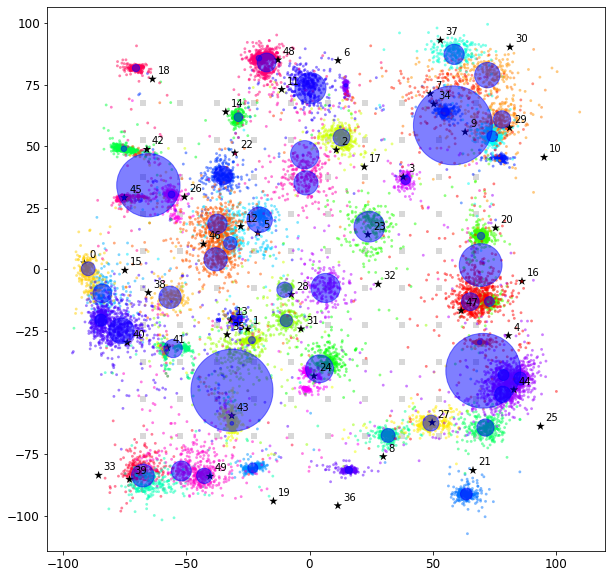

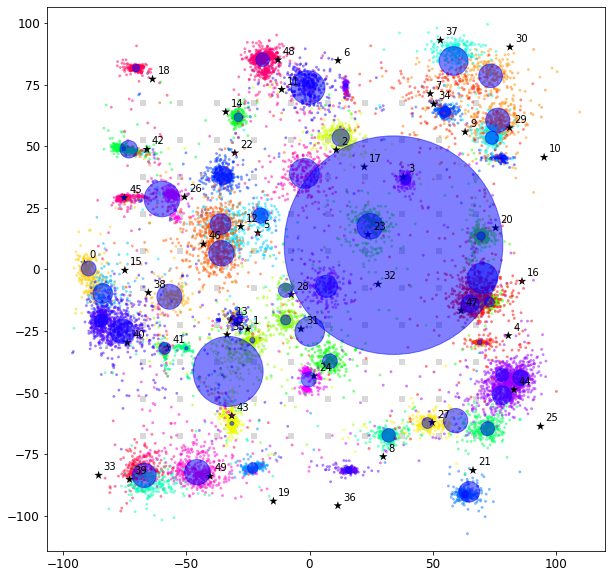

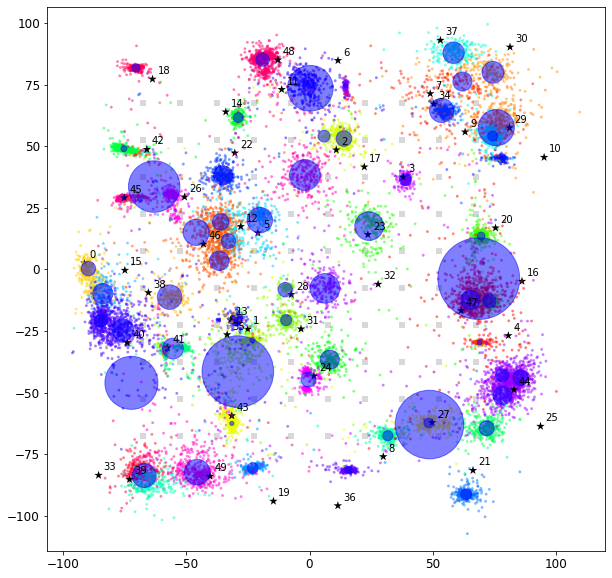

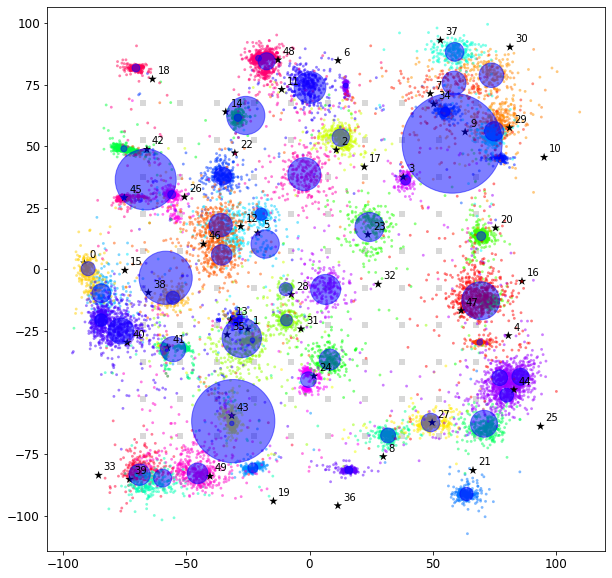

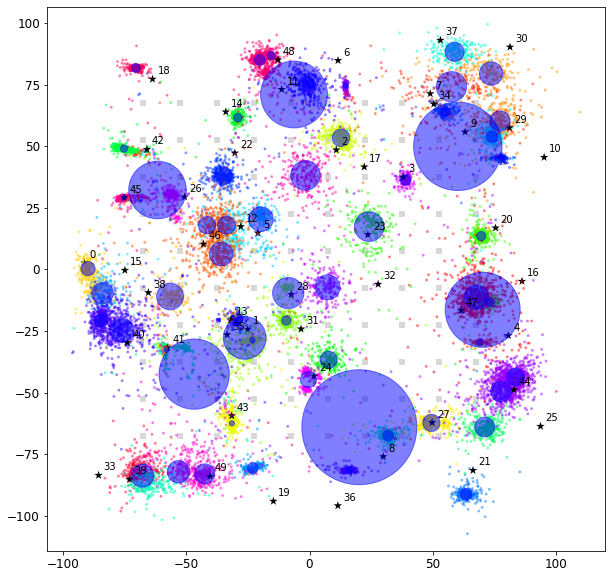

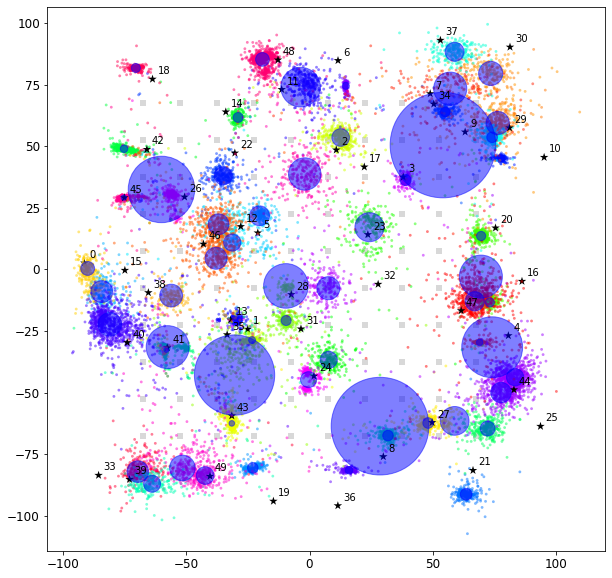

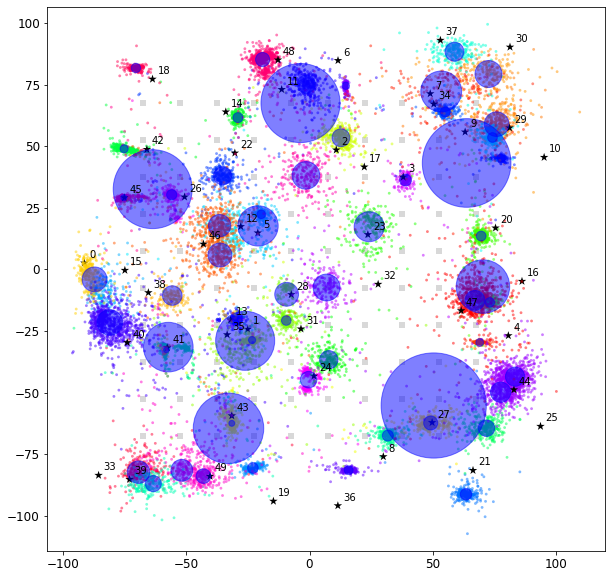

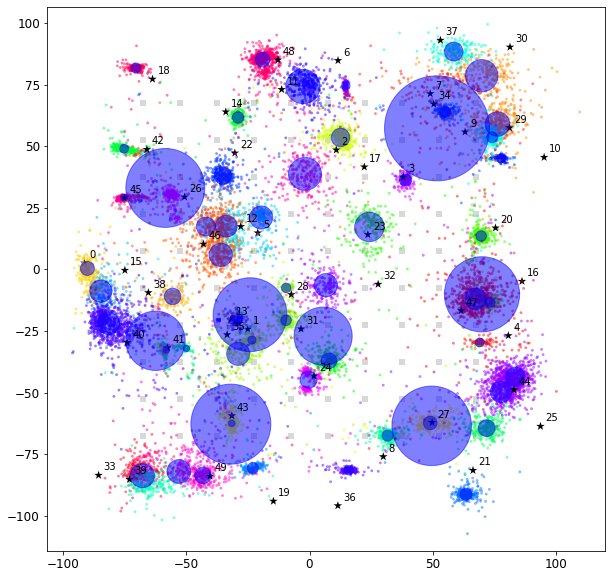

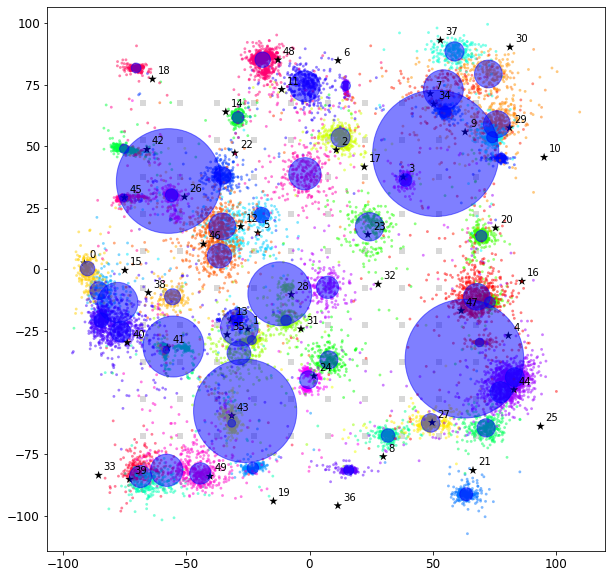

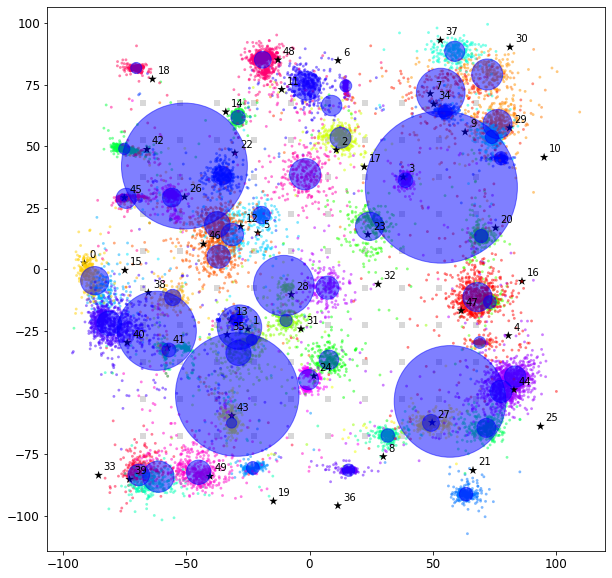

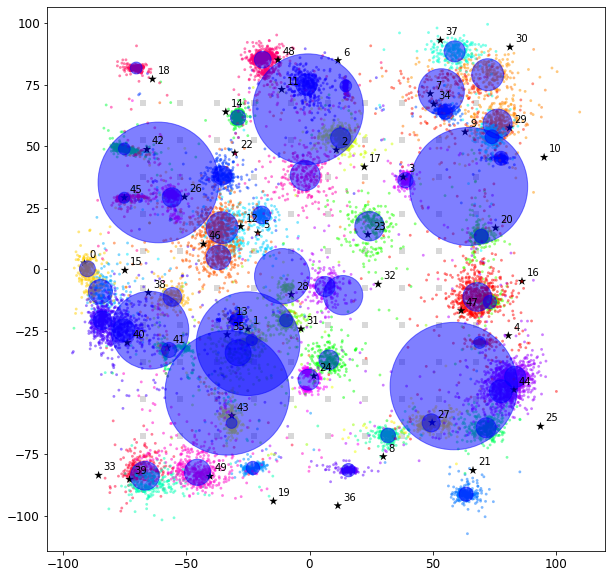

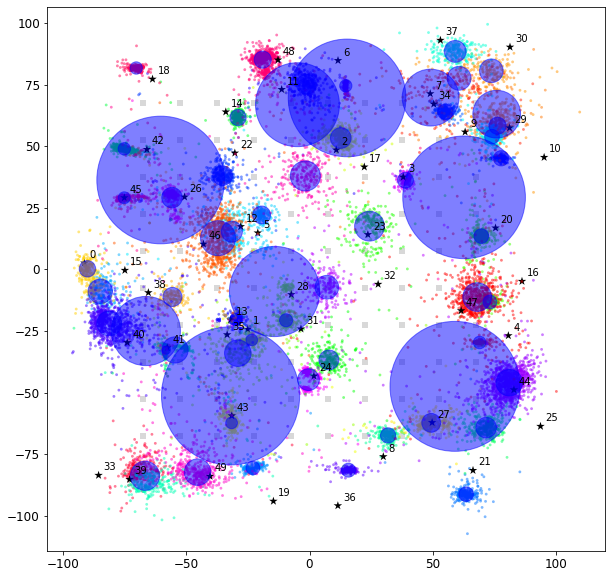

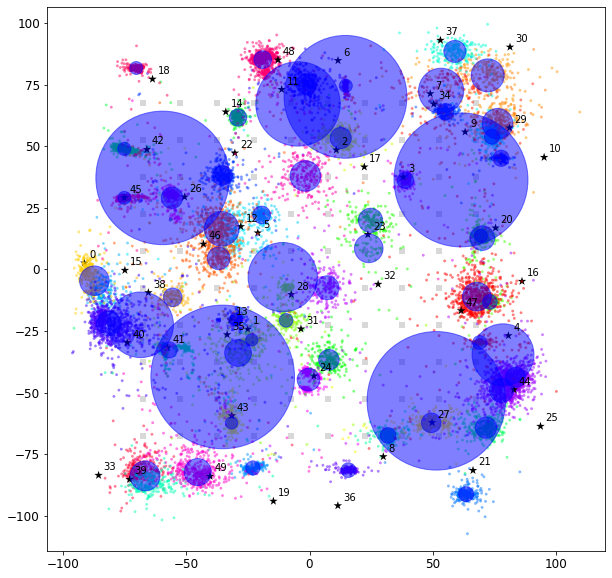

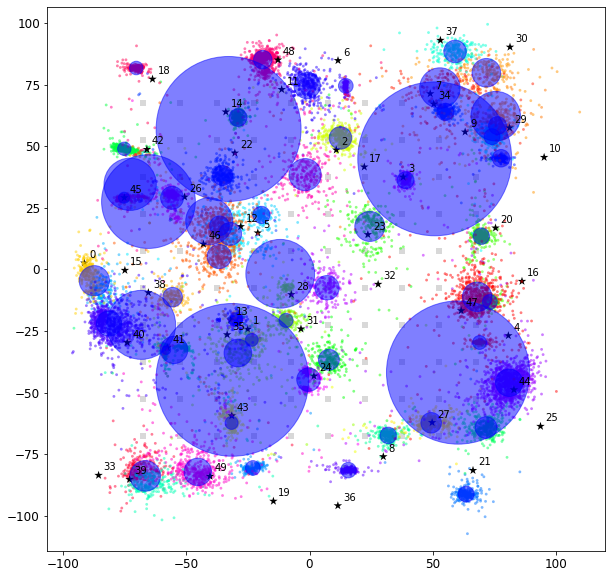

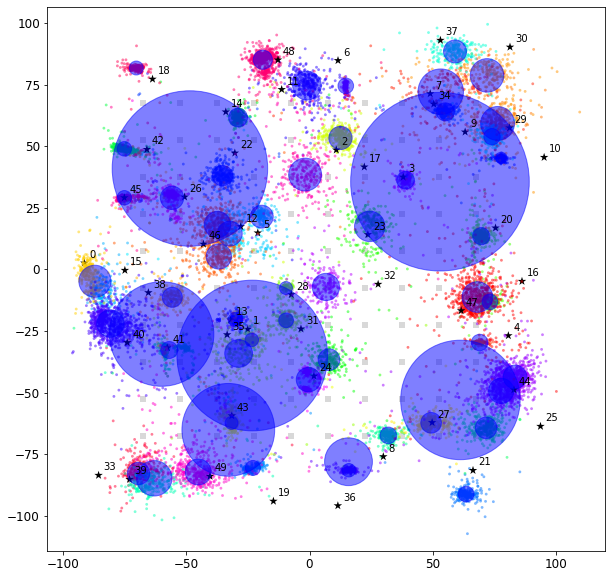

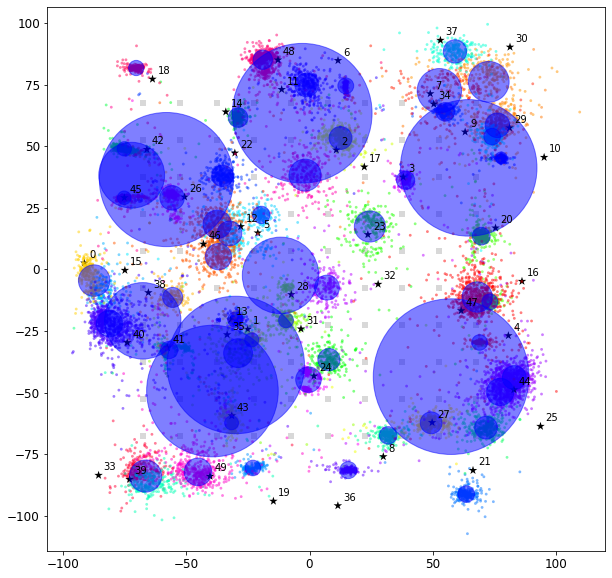

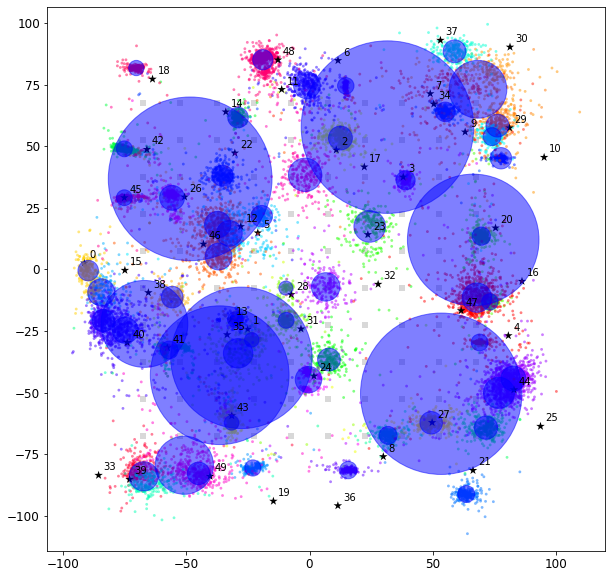

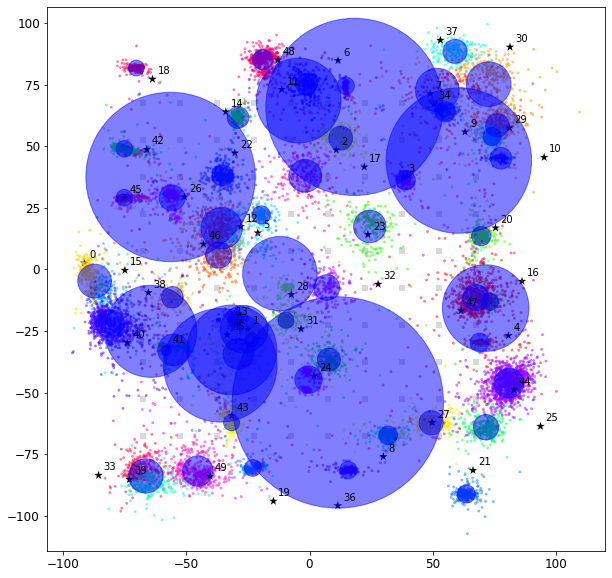

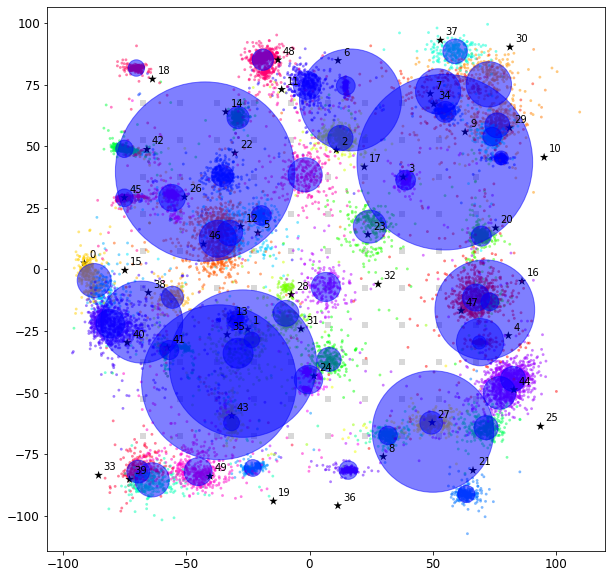

In [36]:
num_neurons = 50
cutout_start = 20
cutout_end = 20
pc_components = 2
#alpha = 8
#bandwidth_com = 5.5
num_clusters = 60
covariance_type = 'spherical'
middle_frame = len(all_neuron_waveforms[0][0])//2

waveforms_list = []
for neuron in range(num_neurons):
    for waveform in all_neuron_waveforms[neuron]:
        waveforms_list.append(waveform[middle_frame-cutout_start:middle_frame+cutout_end])
waveforms_list = np.asarray(waveforms_list)

if(pc_components != 0):
    pca = decomposition.PCA(n_components=pc_components, whiten=True)
    pca.fit(waveforms_list)
    waveforms_pcs_array = pca.transform(waveforms_list)
    all_neuron_pcs = defaultdict(list)
    total_spikes = 0
    for neuron in range(num_neurons):
        for i, _ in enumerate(all_neuron_waveforms[neuron]):
            all_neuron_pcs[neuron].append(waveforms_pcs_array[i + total_spikes])
        total_spikes += len(all_neuron_waveforms[neuron])

accuracy_vae_GMM = []
recall_vae_GMM = []
precision_vae_GMM = []

accuracy_vae_MS_all = []
recall_vae_MS_all = []
precision_vae_MS_all = []

# Clustering with GMM
for alpha in tqdm(range(21)):
#     wandb.log({"alpha": alpha})
    cluster_data = []
    labels = []
    if(pc_components !=0):
        for neuron in range(num_neurons):
            for i, vae_loc in enumerate(vae_locs_3D[neuron]):
                cluster_data.append(np.concatenate((vae_loc[1:3], alpha*all_neuron_pcs[neuron][i])))
                labels.append(neuron)
        cluster_data = np.asarray(cluster_data)
    else:
        for neuron in range(num_neurons):
            for i, vae_loc in enumerate(vae_locs_3D[neuron]):
                cluster_data.append((vae_loc[1:3]))
                labels.append(neuron)
        cluster_data = np.asarray(cluster_data)

    clustering = GaussianMixture(n_components=num_clusters, covariance_type=covariance_type, random_state=0).fit(cluster_data)
    labels =  clustering.predict(cluster_data)

    #Make numpy extractor for method

    SX=se.NumpySortingExtractor()
    SX.set_sampling_frequency(32000)
    times = []
    for neuron in range(num_neurons):
        for time in all_spike_times[neuron]:
            times.append(time)
    times = np.asarray(times)
    for k in np.unique(labels):
        times_k=times[np.where(labels==k)[0]]
        times_k.sort()
        SX.add_unit(unit_id=k,times=times_k)

    cmp = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX, n_jobs=1, match_score=0);
    performance_measures = cmp.get_performance(method='pooled_with_average')

    print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
    print(performance_measures)
    
    accuracy_vae_GMM.append(performance_measures[0])
    recall_vae_GMM.append(performance_measures[1])
    precision_vae_GMM.append(performance_measures[2])
    
#     wandb.log({
#         "accuracy_vae_GMM": performance_measures[0],
#         "recall_vae_GMM": performance_measures[1],
#         "precision_vae_GMM": performance_measures[2],
#         "false_discovery_rate_vae_GMM": performance_measures[3],
#         "miss_rate_vae_GMM": performance_measures[4]
#     })

    recgen = mr.load_recordings(recording_directory + recording_name)
    channel_positions = recgen.channel_positions

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # clustering_plotting_functions.plotClusterResults(channel_positions, cluster_data, labels, soma_positions, dims=[0,1], clustering_alg='gmm', alpha=.15, ax=ax, min_cluster_size=0)
    for i, covar in enumerate(clustering.covariances_):
        mean = clustering.means_[i]
        if covariance_type == 'full':
            covariances = covar[:2, :2]
        elif covariance_type == 'diag':
            covariances = np.diag(covar[:2])
        elif covariance_type == 'spherical':
            covariances =  np.eye(mean.shape[0]) * covar
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1],
                                  180 + angle, color='blue')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')
    clustering_plotting_functions.plot2DLocations(channel_positions, range(num_neurons), vae_locs_3D, soma_positions, dims=[1,2], alpha=.5, ax=ax);
    
#     wandb.log({
#         "Clustering GMM colorful VAE": wandb.Image(plt)
#     })


    accuracy_vae_MS = []
    recall_vae_MS = []
    precision_vae_MS = []
    
    for bandwidth in range(1,21):
#         wandb.log({"bandwidth_vae": bandwidth})
        
        clustering_vae= MeanShift(bandwidth=bandwidth).fit(cluster_data)
        labels_vae =  clustering_vae.predict(cluster_data)

        #plotting
        SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
        SX_vae_ms=se.NumpySortingExtractor()
        SX_vae_ms.set_sampling_frequency(32000)
        times = []
        for neuron in range(num_neurons):
            for time in all_spike_times[neuron]:
                times.append(time)
        times = np.asarray(times)
        for k in np.unique(labels_vae):
            times_k=times[np.where(labels_vae==k)[0]]
            times_k.sort()
            SX_vae_ms.add_unit(unit_id=k,times=times_k)

        cmp_vae_ms = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX_vae_ms, n_jobs=1, match_score=0);
        performance_measures_vae_ms = cmp_vae_ms.get_performance(method='pooled_with_average')

        print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
        print(performance_measures_vae_ms)
        
#         wandb.log({
#             "accuracy_vae_meanshift": performance_measures_vae_ms[0],
#             "recall_vae_meanshift": performance_measures_vae_ms[1],
#             "precision_vae_meanshift": performance_measures_vae_ms[2],
#             "false_discovery_rate_vae_meanshift": performance_measures_vae_ms[3],
#             "miss_rate_vae_meanshift": performance_measures_vae_ms[4]
#         })

        accuracy_vae_MS.append(performance_measures_vae_ms[0])
        recall_vae_MS.append(performance_measures_vae_ms[1])
        precision_vae_MS.append(performance_measures_vae_ms[2])
        
    
    accuracy_vae_MS_all.append(accuracy_vae_MS)
    recall_vae_MS_all.append(recall_vae_MS)
    precision_vae_MS_all.append(precision_vae_MS)
    
    

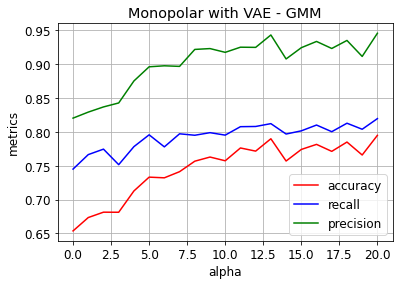

In [40]:
plt.plot(range(0,21),accuracy_vae_GMM, label = 'accuracy', color = 'red')
plt.plot(range(0,21),recall_vae_GMM, label = 'recall', color = 'blue')
plt.plot(range(0,21),precision_vae_GMM, label = 'precision', color = 'green')
plt.xlabel('alpha')
plt.ylabel('metrics')
plt.title('Monopolar with VAE - GMM')
plt.legend()
plt.grid()

# wandb.log({
#     "Alpha for GMM VAE": wandb.Image(plt)
# })

plt.show()

In [38]:
acc_vae_ms = []
re_vae_ms = []
pre_vae_ms = []
for i in range(21):
    acc_vae_ms.append(max(accuracy_vae_MS_all[i]))
    re_vae_ms.append(max(recall_vae_MS_all[i]))
    pre_vae_ms.append(max(precision_vae_MS_all[i]))


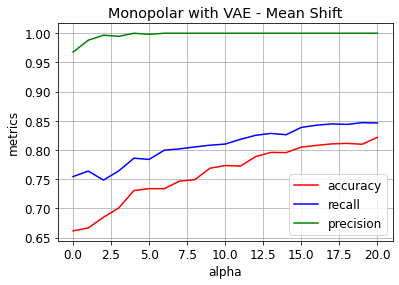

In [41]:
plt.plot(range(0,21),acc_vae_ms, label = 'accuracy', color = 'red')
plt.plot(range(0,21),re_vae_ms, label = 'recall', color = 'blue')
plt.plot(range(0,21),pre_vae_ms, label = 'precision', color = 'green')
plt.xlabel('alpha')
plt.ylabel('metrics')
plt.title('Monopolar with VAE - Mean Shift')
plt.grid()
plt.legend()

# wandb.log({
#     "Alpha for Mean Shift VAE": wandb.Image(plt)
# })
plt.show()


* Alpha 20 and bandwitdh 10 -- best result for mean shift

In [54]:
neu_errors_monopolar_vae =[np.mean(all_vae_errors[i]) for i in all_vae_errors]

In [55]:
neu_errors_monopolar_vae

[18.393574561169768,
 5.25374995177599,
 8.806618293587634,
 4.3812829786403045,
 12.04768874022068,
 8.925267505996112,
 11.08999108876144,
 10.358807478222499,
 9.923375073577247,
 15.447517930656629,
 17.611906887730704,
 14.309492426720533,
 12.496107562369607,
 3.1040886708560564,
 6.724939775560943,
 17.394303646609828,
 16.35318994188597,
 27.629883965847178,
 9.101114362707454,
 17.54748319086615,
 7.901463049208624,
 10.886076141606683,
 12.915970310696538,
 10.62858238677996,
 5.505003444604762,
 23.075907839578324,
 7.193789383304301,
 4.872705282425255,
 10.641718643325818,
 9.242392014876359,
 23.946927890626235,
 18.665822657853894,
 26.006582180524944,
 20.548902958595193,
 18.722806343144754,
 16.13212846985434,
 15.822867971966774,
 10.40346307971563,
 12.695461921249239,
 14.968743637550004,
 15.17777701743559,
 3.416647559849536,
 9.310138213555884,
 4.70997153543797,
 9.624799835796782,
 2.7701112737417897,
 14.512494292727311,
 13.61843937121446,
 8.647472405744756

In [60]:
neu_errors_exponential_vae = [np.mean(all_vae_errors[i]) for i in all_vae_errors]

In [61]:
neu_errors_exponential_vae

[22.684026909139206,
 5.580610073943032,
 5.0817104658792,
 4.074716581279914,
 6.547238671269062,
 4.640337835155674,
 4.0983352376568725,
 8.351050450317755,
 4.729433260524375,
 6.8739488187930355,
 9.103657019704139,
 13.650086455950156,
 11.236679981801664,
 2.221953003596431,
 5.810949787734439,
 8.045111401382407,
 12.683597862128574,
 25.913390401415388,
 13.277789251112228,
 12.803382622516121,
 5.480328895180771,
 14.898114865204354,
 12.269047437925034,
 7.1863986828137465,
 3.284991623368249,
 27.264812924588544,
 4.7943788076912135,
 4.806120878389498,
 6.053173998327492,
 7.517270705153834,
 32.55497191849004,
 19.40091248331849,
 25.11356117931671,
 23.52790848764682,
 16.07262989516571,
 16.186896321619308,
 7.526238437329227,
 11.857274505443385,
 15.40260459882695,
 12.373685997210384,
 12.322989774740616,
 3.4997033883436144,
 6.620961020250026,
 3.565178628663666,
 10.891119798813017,
 2.9985708015965526,
 9.990321376231154,
 10.851629831080606,
 10.491531130809806,

(0.7053020578517508, 34.07162286423472)

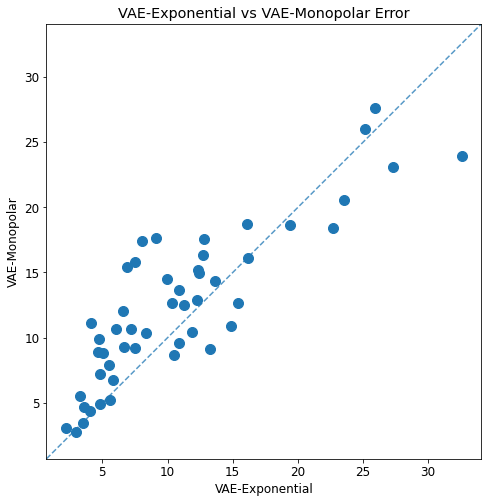

In [81]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(neu_errors_exponential_vae, neu_errors_monopolar_vae, s=100)
plt.xlabel('VAE-Exponential')
plt.ylabel('VAE-Monopolar')
plt.title('VAE-Exponential vs VAE-Monopolar Error')

for i in range(50):
    ax.annotate(str(''), xy=(neu_errors_exponential_vae[i], neu_errors_monopolar_vae[i]))
    
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, '--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)